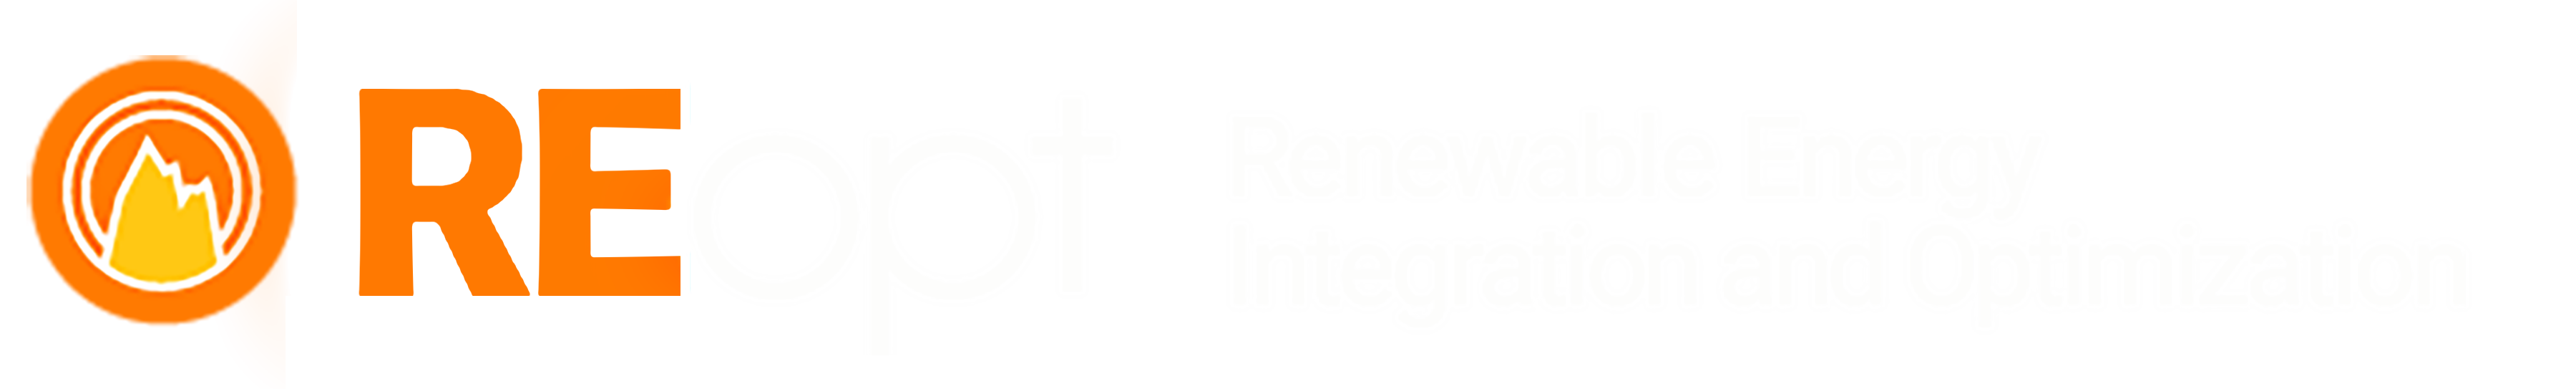

# REopt Analysis Notebook

This notebook provides tools and steps to perform REopt analysis. This notebook includes data tabulation, visualization, and organization. Follow the instructions in each section to obtain the desired results.


### To run your own analysis:
1. Modify the BASE_PATH and SITE_NAME variables below.
2. Prepare your scenario JSON files in the specified directory.
3. Run All

### Required Libraries and External Scripts

The cell below imports necessary Julia modules and includes external Julia scripts essential. Ensure these modules and scripts are available in your environment.


In [1]:
# REopt Scenario Analysis Script
using Revise, Xpress, JuMP, REopt, CSV, PlotlyJS, DataFrames, Statistics, Dates, JSON3, JSON, Serialization, Random, Printf, DataStructures

# Include helper scripts
include("../src/reopt_getdata.jl")
include("../src/reopt_plotting.jl")
include("../src/reopt_runscenarios.jl")
include("../src/reopt_groupedbarplot.jl")

┌ Info: Xpress: Found license file /Applications/FICO Xpress/Xpress Workbench.app/Contents/Resources/xpressmp/bin/xpauth.xpr
└ @ Xpress /Users/bpulluta/.julia/packages/Xpress/DkLV1/src/license.jl:44
┌ Info: Xpress: Development license detected.
└ @ Xpress /Users/bpulluta/.julia/packages/Xpress/DkLV1/src/license.jl:89


plot_bar_charts (generic function with 1 method)

### Configuration Section - USER DEFINED PARAMETERS

In [2]:
# User-defined parameters
BASE_PATH = "../projects/"  # Project directory to populate your analysis
SITE_NAME = "indonesia"       # Your preferred site name
RUN_NEW_ANALYSIS = true     # Set to false to load the latest existing results

true

In [3]:
# Setup project directory and handle file structure
try
    global FOLDER_PATH = setup_project_directory(BASE_PATH, SITE_NAME)
    
    global SITE = basename(FOLDER_PATH) # Extract the SITE name from the project path
    json_path = joinpath(FOLDER_PATH, SITE * "_scenarios.json") # Loading data scenarios

    if isfile(json_path)
        global data = JSON.parsefile(json_path)
        println("Successfully loaded scenarios from $json_path")
        println("Scenario structure:")
        for (group, scenarios) in data[SITE]
            println("  Group: $group")
            for (file, name) in scenarios
                full_path = joinpath(FOLDER_PATH, file)
                status = isfile(full_path) ? "✓" : "✗"
                println("    $status $name ($file)")
            end
        end
    else
        error("JSON file not found in the specified directory at $json_path!")
    end
catch e
    println("\nAn error occurred during setup:")
    println("\nExecution halted. Please address any issues and rerun the notebook.")
    rethrow(e)  # Re-throw the exception to ensure the notebook stops here
end

println("\nSetup completed successfully. You can proceed with the next steps.")

Directory already exists: ../projects/indonesia
Directory already exists: ../projects/indonesia/scenarios
Existing scenarios file found: ../projects/indonesia/indonesia_scenarios.json
Scenarios file saved: ../projects/indonesia/indonesia_scenarios.json
Successfully loaded scenarios from ../projects/indonesia/indonesia_scenarios.json
Scenario structure:
  Group: Cost-Optimal
    ✓ 0A. BAU (scenarios/1-baseline.json)
    ✓ 1A. Base Case (scenarios/1-baseline.json)
    ✓ 1B. BESS 500 per kwh (scenarios/2-BESS-500.json)

Setup completed successfully. You can proceed with the next steps.


### STEP 1: Define Site and Scenarios - DO NOT EDIT

The cell below organizes the difference scenario JSONs into a dictionary that will run all JSONs together to get the results for all of the configured files


In [4]:
site_data     =   data[SITE]
all_scenarios =   Dict{String,Vector{Tuple{String,String}}}()
for (case, scenarios) in site_data
    converted_scenarios =   Vector{Tuple{String,String}}()
    for scenario in scenarios
        absolute_scenario_path =   joinpath(FOLDER_PATH, scenario[1])
        push!(converted_scenarios, (absolute_scenario_path, scenario[2]))
    end
    all_scenarios[case] =   converted_scenarios
end

# Initialize variables to hold results
reoptsim_results =   []
results          =   []

# Use the results_dir as the base path for creating versioned directories
results_dir = create_next_version_dir(FOLDER_PATH)


RUN_NEW_ANALYSIS:true
Created new directory: ../projects/indonesia/results_20240919_v7


"../projects/indonesia/results_20240919_v7"

### Check Inputs for Accuracy

This creates a _csv_ file with all of the inputs used in each scenario. Use this to check that all of the scenarios were properly built with the correct technology and assumptios

In [5]:
# Prepare and save input data
try
    table_data, col_names = prepare_table_data(all_scenarios)
    df1 = DataFrame(table_data, Symbol.(col_names))
    CSV.write(joinpath(FOLDER_PATH, "$SITE-inputs.csv"), df1)
    println("Input data saved to: $(joinpath(FOLDER_PATH, "$SITE-inputs.csv"))")
catch e
    error("Error preparing input data: $e")
end

Input data saved to: ../projects/indonesia/indonesia-inputs.csv


### Map

Latitude: 0.9069875
Longitude: 126.3120156


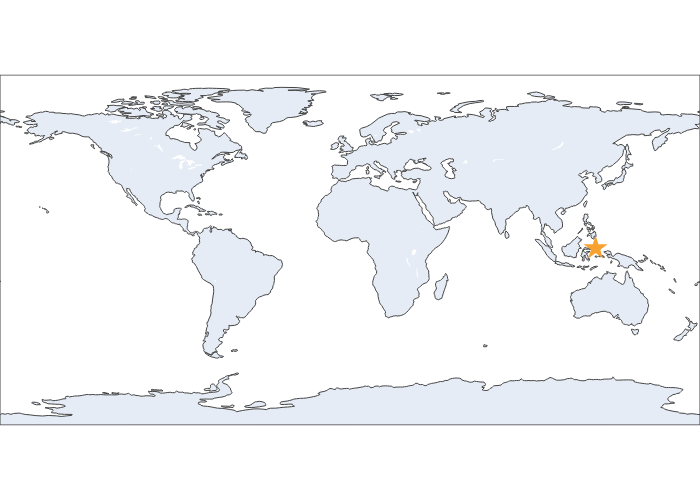

In [6]:
# Plot scenario locations
try
    plot_scenario_location(all_scenarios, FOLDER_PATH, SITE)
catch e
    error("Error plotting scenario locations: $e")
end

### STEP 2: Run REopt (Execute Scenarios) - DO NOT EDIT

The cell below either runs the scenarios or loads saved results based on the `rerun_scenarios` flag. It's advisable not to modify this cell unless you know what you're doing.


In [7]:
# Run analysis or load existing results
global all_results = Dict()
if RUN_NEW_ANALYSIS
    for (case, scenarios) in all_scenarios
        println("Running scenarios for $SITE - Case $case")
        reoptsim_results, results = run_and_get_results(scenarios, case, results_dir; mip_rel_stop=0.5)
        all_results[case] = (reoptsim_results, results)
    end
else
    for case in keys(all_scenarios)
        println("Loading Results for $SITE - Case $case")
        reoptsim_results = deserialize(open(joinpath(results_dir, "$case-reopt_results.bin"), "r"))
        results = deserialize(open(joinpath(results_dir, "$case-results.bin"), "r"))
        all_results[case] = (reoptsim_results, results)
    end
end

Running scenarios for indonesia - Case Cost-Optimal
=========================== Running scenario: 0A. BAU ===========================


┌ REopt | Warn: Setting PV can_net_meter, can_wholesale, and can_export_beyond_nem_limit to False because `off_grid_flag` is true.
└ @ REopt /Users/bpulluta/.julia/packages/REopt/4BYDl/src/core/pv.jl:154
┌ REopt | Warn: Could not look up EASIUR health costs from point (0.9069875,126.3120156). Location is likely invalid or outside the CAMx grid.
└ @ REopt /Users/bpulluta/.julia/packages/REopt/4BYDl/src/core/financial.jl:245
┌ REopt | Warn: Could not look up EASIUR health cost escalation rates from point (0.9069875,126.3120156). Location is likely invalid or outside the CAMx grid
└ @ REopt /Users/bpulluta/.julia/packages/REopt/4BYDl/src/core/financial.jl:275
┌ REopt | Warn: Could not find AVERT region containing site latitude/longitude. Checking site proximity to AVERT regions.
└ @ REopt /Users/bpulluta/.julia/packages/REopt/4BYDl/src/core/electric_utility.jl:394
┌ REopt | Warn: Your site location (0.9069875, 126.3120156) is more than 5 miles from the nearest AVERT region. Cannot calcula

=========================== Running scenario: 1A. Base Case ===========================
Reusing results from previous scenario for: 1A. Base Case


Results processing took 6.202 seconds.
└ @ REopt /Users/bpulluta/.julia/packages/REopt/4BYDl/src/core/reopt.jl:553


=========================== Running scenario: 1B. BESS 500 per kwh ===========================


┌ REopt | Warn: Setting PV can_net_meter, can_wholesale, and can_export_beyond_nem_limit to False because `off_grid_flag` is true.
└ @ REopt /Users/bpulluta/.julia/packages/REopt/4BYDl/src/core/pv.jl:154
┌ REopt | Warn: Could not look up EASIUR health costs from point (0.9069875,126.3120156). Location is likely invalid or outside the CAMx grid.
└ @ REopt /Users/bpulluta/.julia/packages/REopt/4BYDl/src/core/financial.jl:245
┌ REopt | Warn: Could not look up EASIUR health cost escalation rates from point (0.9069875,126.3120156). Location is likely invalid or outside the CAMx grid
└ @ REopt /Users/bpulluta/.julia/packages/REopt/4BYDl/src/core/financial.jl:275
┌ REopt | Warn: Could not find AVERT region containing site latitude/longitude. Checking site proximity to AVERT regions.
└ @ REopt /Users/bpulluta/.julia/packages/REopt/4BYDl/src/core/electric_utility.jl:394
┌ REopt | Warn: Your site location (0.9069875, 126.3120156) is more than 5 miles from the nearest AVERT region. Cannot calcula

### STEP 3: Process Results - DO NOT EDIT

The cell below processes the results to create visualization and data charts


In [8]:
# Post-process results
for (case, scenarios) in all_scenarios  # Changed from all_scenarios
    reoptsim_results, results      =   all_results[case]
    # curr_gen_size                  =   get(reoptsim_results[1], "Generator", Dict("size_kw" => 0))["size_kw"] #workaround for existing generator comparison
    println("=========================== Processing results for $SITE - Case $case ===========================")
    post_process_results(SITE, scenarios, reoptsim_results, results, case, results_dir, 0)
end

=========================== Processing results for indonesia - Case Cost-Optimal ===========================
Skipping outage simulation for off-grid scenario: 0A. BAU
Skipping outage simulation for off-grid scenario: 1A. Base Case
Skipping outage simulation for off-grid scenario: 1B. BESS 500 per kwh
Raw data saved successfully to Cost-Optimal-indonesia-Raw-Data.json
Key 'electric_to_load_series_kw_bau' not found in 'ElectricUtility'.


### STEP 4: Get Pretty Plots

The cells below can be modified to include difference variables that might be interesting to compare against different scenarios.


In [9]:
# Define columns for bar charts
columns = [
    "PV-New Size (kW-DC)",
    "PV Size (kW-DC)",
    "PV-Existing Size (kW-DC)",
    "Battery Size (kW)",
    "Battery Capacity (kWh)",
    "CHP (kW)",
    "Current Gen. Capacity (kW)",
    "Wind Size (kW)",
    "Add-on Gen. Capacity (kW)",
    "Wind Size (kW)",
    "Net Present Value (NPV) (\$)",
    "Payback Period (Years)",
    "Lifecycle CO2 Reduction (%)",
    "Total Capital Costs (including replacements and incentives) (\$)",
    "Microgrid LCOE"
]

# Select scenarios for comparison (1 is BAU, use [2,3,4,5] to select specific scenarios or leave selected_scenarios = [] empty and it will plot all scenarios)
selected_scenarios = []

# Plot bar charts for each case
for (case, scenarios) in all_scenarios
    println("Plotting charts for $SITE - Case $case")
    plot_bar_charts(results_dir, SITE, selected_scenarios, case, columns)
end

println("Analysis complete. Results and plots are saved in: $results_dir")

Plotting charts for indonesia - Case Cost-Optimal
Analysis complete. Results and plots are saved in: ../projects/indonesia/results_20240919_v7


### Useful .json RAW data verification

In [10]:
# wind_annual = sum(all_results["NETZERO"][1][2]["Wind"][1]["electric_to_storage_series_kw"]) + sum(all_results["NETZERO"][1][2]["Wind"][1]["electric_to_grid_series_kw"]) + sum(all_results["NETZERO"][1][2]["Wind"][1]["electric_to_load_series_kw"]) + sum(all_results["NETZERO"][1][2]["Wind"][1]["electric_curtailed_series_kw"]) 

In [11]:
# all_results["NETZERO"][1][2]["Wind"][1]["annual_energy_produced_kwh"]